# Modelos de Clustering 

Nicole Lastra Quiroz - Agosto 2022



## Importación de librerías

In [20]:
# Para tratamiento de los datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import pingouin as pg
import statsmodels.api as sm
import multiprocessing
import os
import quadprog

# Para gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.font_manager
from matplotlib import style
#style.use('ggplot') or plt.style.use('ggplot')
import seaborn as sns
#from mlxtend.plotting import plot_decision_regions


#Para preprocesado y modelado
# ------------------------------------------------------------------------------

from pandas.core.series import Series
from sklearn.datasets import load_boston
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage

# Para configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

## Importación de datos

In [21]:
# Importación de datos:
# ------------------------------------------------------------------------------
salario = pd.read_excel('Base_de_Datos_completa.xls', 
                        sheet_name = 'Salarios'
                       )

## Visualización de los datos

In [22]:
# Visualizació de las primeras 7 filas de datos
# ------------------------------------------------------------------------------
salario.head(7)

,Ciudad,profesor,chofer,mecánico,cocinero,administrador,ingeniero,cajero
0,Abu Dhabi,16800,15336,8996,31562,26520,31635,11960
1,Amsterdam,34125,29820,26642,37067,59280,47730,32200
2,Atenas,11025,10650,12456,19451,31980,18870,16100
3,Bhrain,10500,5112,6574,14680,56940,44955,18400
4,Bangkok,3150,3408,3460,12478,14820,7770,3680
5,Bogotá,4725,3408,3806,12478,14040,14430,3220
6,Bruselas,28350,26412,25258,24589,59280,33855,38640


In [23]:
# Información general
# ------------------------------------------------------------------------------
salario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Ciudad         44 non-null     object
 1   profesor       44 non-null     int64 
 2   chofer         44 non-null     int64 
 3   mecánico       44 non-null     int64 
 4   cocinero       44 non-null     int64 
 5   administrador  44 non-null     int64 
 6   ingeniero      44 non-null     int64 
 7   cajero         44 non-null     int64 
dtypes: int64(7), object(1)
memory usage: 2.9+ KB


**Hallazgos Principales:**
- No existen valores nulos en ninguna de las variables.
- La variable `Ciudad` es categórica.
- El resto de las variables son numéricas.

In [24]:
# Información estadística preliminar de las variables numéricas
# ------------------------------------------------------------------------------
salario.describe()


,profesor,chofer,mecánico,cocinero,administrador,ingeniero,cajero
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,20117.045455,18354.727273,17583.113636,23638.136364,40240.909091,33461.227273,19497.727273
std,13245.694532,11533.631293,10653.796396,11142.438165,19419.160978,14486.026555,11145.234223
min,2100.000000,2130.000000,1730.000000,4771.000000,7800.000000,4440.000000,3220.000000
25%,9318.750000,7561.500000,8563.500000,14680.000000,23205.000000,23865.000000,11385.000000
50%,18900.000000,16827.000000,16781.500000,21102.500000,41730.000000,34132.500000,17940.000000
75%,29531.250000,26412.000000,25258.000000,31562.000000,59280.000000,43983.750000,24840.000000
max,56700.000000,44304.000000,39790.000000,50279.000000,71760.000000,63270.000000,46000.000000


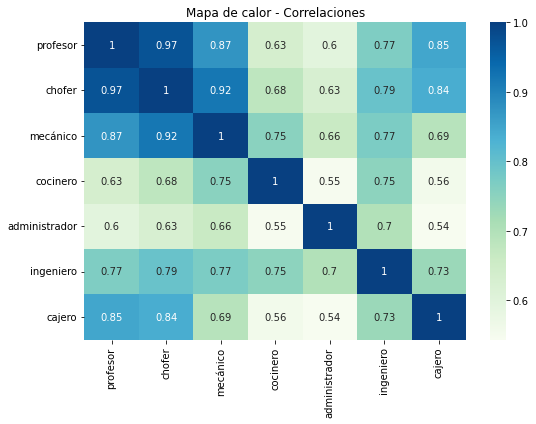

In [25]:
# Mapa de Calor para datos numéricos
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize =(8,6))

sns.heatmap(salario.corr(), 
            ax    = ax,
            annot   = True,
            cmap  = 'GnBu'
            )
plt.title('Mapa de calor - Correlaciones')
plt.tight_layout()
plt.show()

**Hallazgos Principales:**
- Destacan en las correlaciones por sobre el 90%: `chofer` y `profesor` (del orden del 97%),  `mecánico` y `chofer` (del orden del 92%).
- En general, la mayoría de las variables presentan correlaciones directas por sobre el 50%.

Como complemento a la gráfica, se procede a revisar la matriz de correlación numérica para revisar los valores exactos.

In [26]:
# Matriz de correlación de pearson
# ------------------------------------------------------------------------------
salario.corr()

,profesor,chofer,mecánico,cocinero,administrador,ingeniero,cajero
profesor,1.000000,0.971944,0.874464,0.633622,0.595184,0.767959,0.846575
chofer,0.971944,1.000000,0.918899,0.680333,0.627839,0.793456,0.836570
mecánico,0.874464,0.918899,1.000000,0.752694,0.662421,0.770620,0.690224
cocinero,0.633622,0.680333,0.752694,1.000000,0.548151,0.749285,0.556479
administrador,0.595184,0.627839,0.662421,0.548151,1.000000,0.699252,0.543218
ingeniero,0.767959,0.793456,0.770620,0.749285,0.699252,1.000000,0.731887
cajero,0.846575,0.836570,0.690224,0.556479,0.543218,0.731887,1.000000


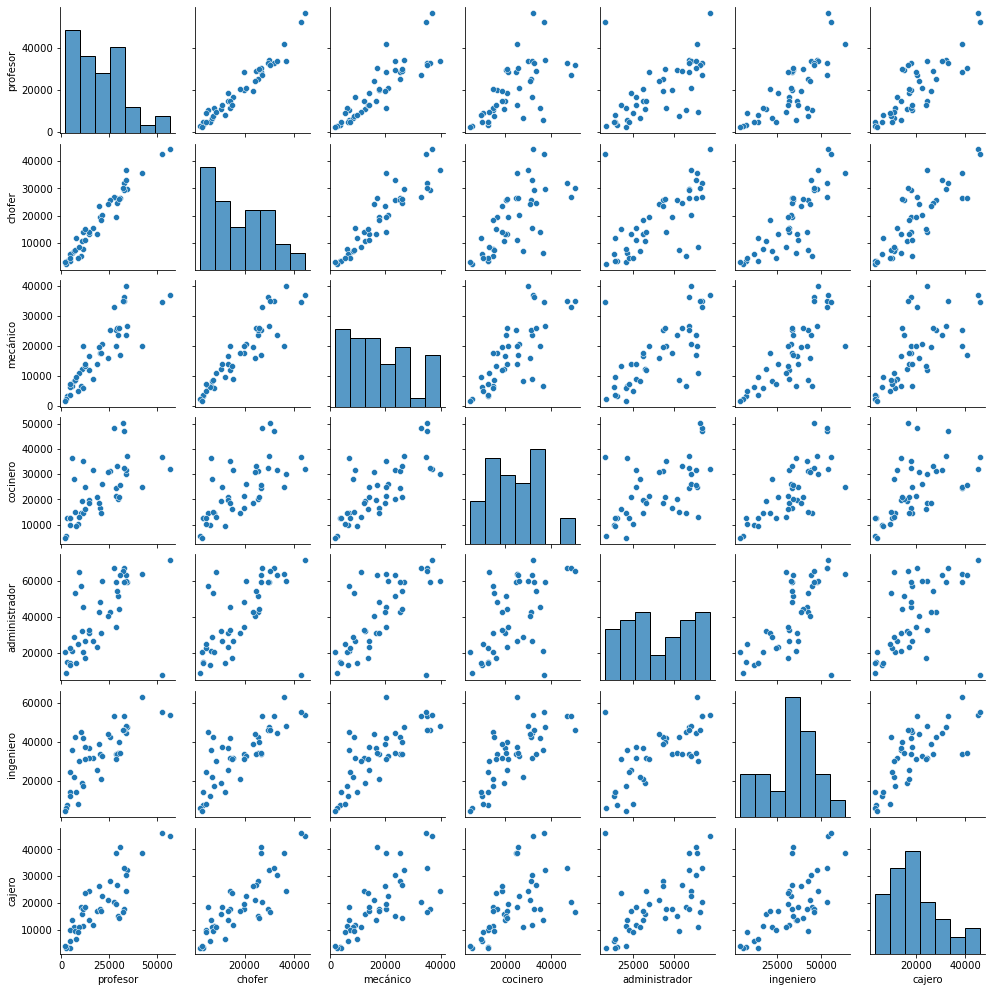

In [27]:
# Gráfico mixto
# ------------------------------------------------------------------------------
sns.pairplot(salario, height = 2)
plt.show()

Con esta gráfica se re afirman las suposiciones y hallazgos ya comentados. Ahora se procederá a revisar los boxplots en busqueda de un mejor detalle respecto a posición.

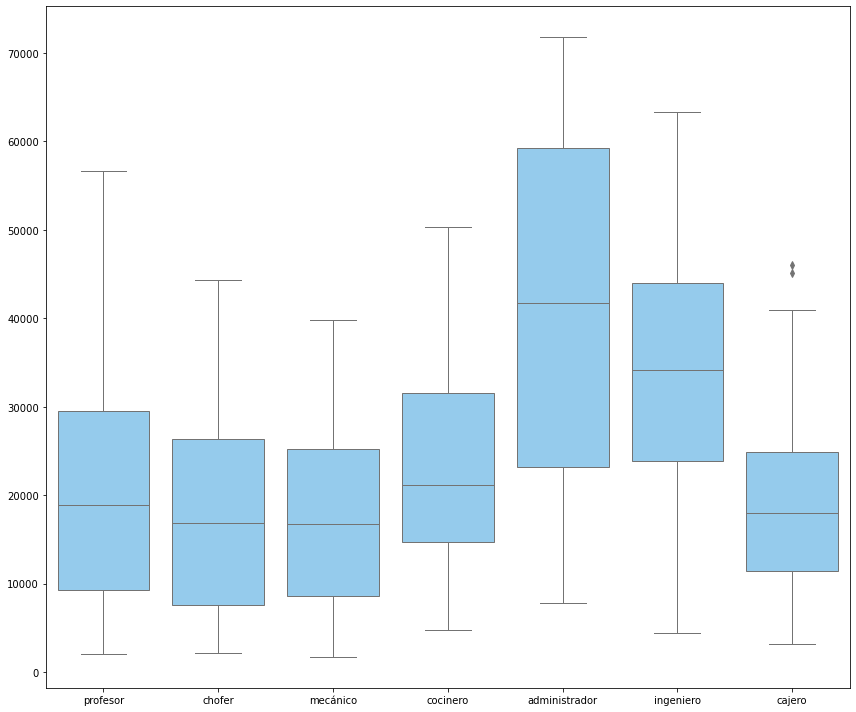

In [28]:
# Comparativa de Boxplots 1
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize =(12,10))

ax = sns.boxplot (data      = salario, 
                  orient    = 'v',
                  color     = 'lightskyblue', 
                  linewidth = 1)

plt.tight_layout()
plt.show()

**Hallazgos principales**
- La variable `administrador` se distribuye en un rango superior al de las otras variables, y de hecho es la variable que alcanza los salarios más altos.

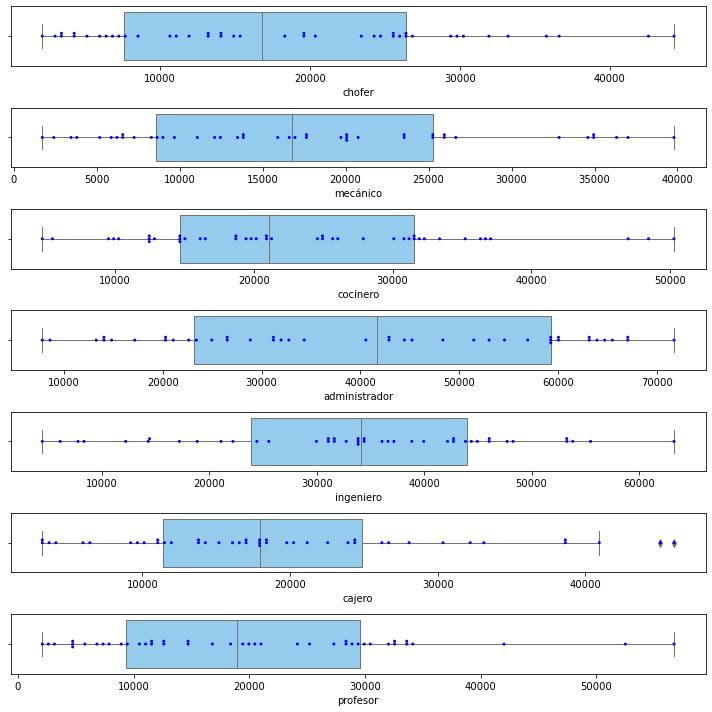

In [29]:
# Boxplots para cada columna numérica
# ------------------------------------------------------------------------------
num   = salario._get_numeric_data()
names = list(num.columns)
f, axes = plt.subplots(round(len(names)/1), 1, figsize = (10, 10))  
y = 0;
for name in names:
    i, j = divmod((y-1), 1)
    sns.boxplot(
        x         = num[name], 
        ax        = axes[i],
        color     = "lightskyblue",
        linewidth = 1
    )
    
    sns.swarmplot(
        x         = num[name], 
        ax        = axes[i],
        data      = salario, 
        orient    = 'h', 
        color     = "blue",
        size      = 3,
    )
    y = y + 1
plt.tight_layout()
plt.show()

**Hallazgos principales**
- La variable `cajero` posee datos atípicos.
- Los datos de las variables `cocinero`, `profesor` y en menor caso `mecánico`, presentan distribuciones de datos más dispersas entre el tercer y cuarto cuartil.
- El resto de variables se distribuye de forma relativamente uniforme a lo largo del boxplot.

## Limpieza y extracción de datos

### Valores nulos

No existen variables con valores nulos por lo que no se requiere eliminar valores, o filas de datos.

### Datos fuera de rango

Sólo se observaron dos datos atípicos en la variable `cajero`, pero dada la baja cantidad de datos, no se eliminarán del estudio en esta ocasión.

### Datos duplicados

In [30]:
# Conteo previa eliminación de duplicados
# ------------------------------------------------------------------------------
print('Antes de eliminar duplicados', len(salario))

# Eliminado de duplicados
# ------------------------------------------------------------------------------
salario2 = salario.drop_duplicates()

# Conteo post eliminación de duplicados
# ------------------------------------------------------------------------------
print('Después de eliminar duplicados', len(salario2))

Antes de eliminar duplicados 44
Después de eliminar duplicados 44


Se puede apreciar que no existen datos duplicados, por lo que se seguirá utilizando el data frame original.

## Modelado de los datos

### PCA

Para efectos de estudio de reducción de dimensionalidad, primero realizaremos un `PCA` para proseguir con un `K-Means`.

Primero revisamos específicamente las medias y la varianza de las variables para identificar si necesitamos hacer un escalado (pese a que para efectos de práctica, más adelante se realizará de igual forma).

In [31]:
# Media de los datos
# ------------------------------------------------------------------------------
print('----------------------')
print('Media de cada variable')
print('----------------------')
salario.mean(axis=0)

----------------------
Media de cada variable
----------------------


profesor         20117.045455
chofer           18354.727273
mecánico         17583.113636
cocinero         23638.136364
administrador    40240.909091
ingeniero        33461.227273
cajero           19497.727273
dtype: float64

In [32]:
# Varianza de los datos
# ------------------------------------------------------------------------------
print('-------------------------')
print('Varianza de cada variable')
print('-------------------------')
salario.var(axis=0)

-------------------------
Varianza de cada variable
-------------------------


profesor         1.754484e+08
chofer           1.330247e+08
mecánico         1.135034e+08
cocinero         1.241539e+08
administrador    3.771038e+08
ingeniero        2.098450e+08
cajero           1.242162e+08
dtype: float64

Se concluye que no es imperativo realizar el escalado de las variables (pese a que etapas futuras se realizará de igual forma, como se explicó anteriormente).

In [33]:
# Entrenamiento modelo PCA con escalado de los datos
# ------------------------------------------------------------------------------
pca_pipe = make_pipeline(StandardScaler(), PCA())
pca_pipe.fit(salario.drop(columns = 'Ciudad'))

# Se extrae el modelo entrenado del pipeline
# ------------------------------------------------------------------------------
modelo_pca = pca_pipe.named_steps['pca']

In [34]:
# Se combierte el array a dataframe para añadir nombres a los ejes
# ------------------------------------------------------------------------------
pd.DataFrame(
    data    = modelo_pca.components_,
    columns = salario.drop(columns='Ciudad').columns,
    index   = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5','PC6','PC7']
)

,profesor,chofer,mecánico,cocinero,administrador,ingeniero,cajero
PC1,0.402979,0.412414,0.400021,0.343664,0.323927,0.386730,0.367303
PC2,0.368263,0.279397,-0.011532,-0.428622,-0.591839,-0.221299,0.450802
PC3,-0.040181,0.004636,0.158714,0.686062,-0.680587,0.020423,-0.197172
PC4,-0.206846,-0.258613,-0.555567,0.160729,-0.105890,0.477085,0.563048
PC5,-0.063955,-0.065648,-0.085125,0.407997,0.246902,-0.755105,0.432143
PC6,0.588924,0.198441,-0.670005,0.187471,0.096920,-0.054669,-0.342572
PC7,0.553777,-0.800788,0.223276,-0.007482,-0.005635,0.016358,0.043156


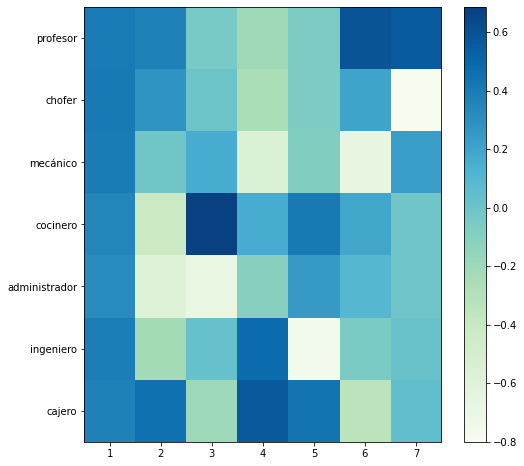

In [53]:
# Mapa de calor de componentes
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
componentes = modelo_pca.components_

plt.imshow(componentes.T, 
           cmap   = 'GnBu', 
           aspect = 'auto'
          )

plt.yticks(range(len(salario.drop(columns = 'Ciudad').columns)), 
           salario.drop(columns = 'Ciudad').columns
          )
plt.xticks(range(len(salario.drop(columns = 'Ciudad').columns)), 
           np.arange(modelo_pca.n_components_) + 1
          )
plt.grid(False)
plt.colorbar();

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.77002125 0.08440713 0.06574494 0.04293409 0.02407881 0.00979426
 0.00301953]


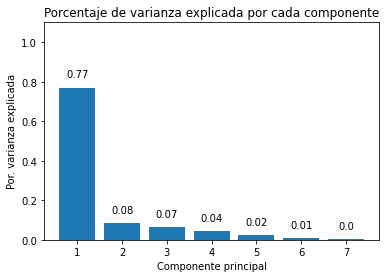

In [36]:
# Gráfico del porcentaje de varianza explicada por cada componente
# ------------------------------------------------------------------------------
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(salario.drop(columns = 'Ciudad').columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords = "offset points",
        xytext     = (0,10),
        ha         = 'center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.77002125 0.85442838 0.92017331 0.9631074  0.98718621 0.99698047
 1.        ]


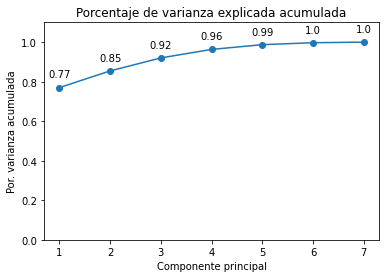

In [37]:
# Gráfico del porcentaje de varianza acumulada explicada
# ---------------------------------------------------------------------
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(salario.drop(columns='Ciudad').columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(salario.drop(columns='Ciudad').columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

Si se utilizaran sólo las 2 primeras componentes, se explicaría un 85% de la varianza.

In [38]:
# Proyección de las observaciones de entrenamiento
# ---------------------------------------------------------------------
proyecciones = pca_pipe.transform(X = salario.drop(columns = 'Ciudad'))
proyecciones = pd.DataFrame(proyecciones,
    columns  = ['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6','PC7'],
    index    = salario.drop(columns = 'Ciudad').index
)
proyecciones.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-0.822329,-0.323376,0.991801,0.319104,0.020666,0.651478,-0.143277
1,2.738897,-0.145300,0.052645,0.256233,0.280453,0.128529,0.030559
2,-1.530571,0.065182,0.019576,-0.086435,0.504987,-0.168473,0.023213
3,-0.917024,-0.971696,-1.255711,1.137009,-0.553947,-0.040559,0.299986
4,-3.597467,0.139823,0.285721,-0.334827,0.277032,0.146823,-0.043467


### K-Means

En primera instancia, se considerará lo trabajado en la reducción de dimensionalidad, para realizar un clustering por `K-Means`, utilizando sólo las primeras dos componentes, y la división comparativa de 2 y 5 clusters.

In [39]:
salarior = proyecciones[['PC1','PC2']]
salarior.head(7)


,PC1,PC2
0,-0.822329,-0.323376
1,2.738897,-0.145300
2,-1.530571,0.065182
3,-0.917024,-0.971696
4,-3.597467,0.139823
5,-3.384495,0.086046
6,1.836019,0.573747


In [40]:
# Creación del modelo 0
# ---------------------------------------------------------------------
modelo0_kmeans = KMeans(
      n_clusters   = 2, 
      n_init       = 20, 
      random_state = 123
)
modelo0_kmeans.fit(X = salarior)

# Clasificación con el modelo 0 kmeans
# ---------------------------------------------------------------------
y_predict0 = modelo0_kmeans.predict(X = salarior)

In [41]:
# Creación del modelo 00
# ---------------------------------------------------------------------
modelo00_kmeans = KMeans(
       n_clusters   = 5, 
       n_init       = 20, 
       random_state = 123
)
modelo00_kmeans.fit(X = salarior)

# Clasificación con el modelo 00 kmeans
# ---------------------------------------------------------------------
y_predict00 = modelo00_kmeans.predict(X = salarior)

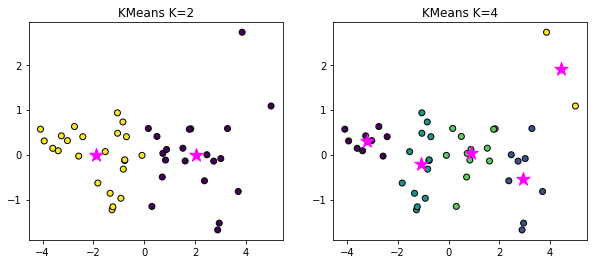

In [42]:
# Comparativa gráfica de modelos
# ---------------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Resultados para K = 2
# ---------------------------------------------------------------------
ax[0].scatter(
        x = salarior['PC1'],
        y = salarior['PC2'], 
        c = y_predict0,
        marker    = 'o',
        edgecolor = 'black'
    )

ax[0].scatter(
    x = modelo0_kmeans.cluster_centers_[:, 0],
    y = modelo0_kmeans.cluster_centers_[:, 1], 
    c = 'magenta',
    s = 200,
    marker = '*',
    label  = 'centroides'
)

ax[0].set_title('KMeans K=2');

# Resultados para K = 4
# ---------------------------------------------------------------------
ax[1].scatter(
        x = salarior['PC1'],
        y = salarior['PC2'], 
        c = y_predict00,
        marker    = 'o',
        edgecolor = 'black'
    )
ax[1].scatter(
    x = modelo00_kmeans.cluster_centers_[:, 0],
    y = modelo00_kmeans.cluster_centers_[:, 1], 
    c = 'magenta',
    s = 200,
    marker = '*',
    label  = 'centroides'
)

ax[1].set_title('KMeans K=4');

En ambos casos se observan clusters sin superposición de valores, pero pareciera ser que en `k = 2` se obtiene una división con mayor precisión.

De igual forma, se revisará cuál sería el número ideal de éstos:

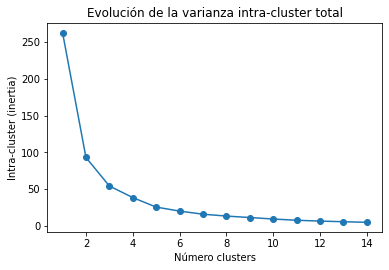

In [43]:
# Método elbow para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo000_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 20, 
                        random_state = 123
                    )
    modelo000_kmeans.fit(salarior)
    inertias.append(modelo000_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

Al revisar por técnica del codo, podría considerarse que el número ideal es de 2 clusters (en `k = 3` ya se comienza a generar un patrón, pero de igual forma, según punto de vista de quien realiza el estudio, podría considerar `k = 3` un número más apropiado que `k = 2`, por lo que se podría complementar con otro método para tomar la decisión final).

**K-Means general**

Dada la baja cantidad de datos, se realizará un K-means considerando la totalida de estos.

In [44]:
# Escalado de las variables
# ----------------------------------------------------------------------
salario_scaled = scale(X         = salario.drop(columns = 'Ciudad'), 
                       axis      = 0, 
                       with_mean = True, 
                       with_std  = True
                      )
salario_s = pd.DataFrame(salario_scaled, 
                         columns = salario.drop(columns ='Ciudad').columns, 
                         index   = salario['Ciudad'].tolist()
                        )
salario_s.head(5)

,profesor,chofer,mecánico,cocinero,administrador,ingeniero,cajero
Abu Dhabi,-0.253320,-0.264759,-0.815333,0.719364,-0.714734,-0.127526,-0.684137
Amsterdam,1.069774,1.005566,0.860127,1.219133,0.991763,0.996390,1.152881
Atenas,-0.694351,-0.675746,-0.486811,-0.380127,-0.430318,-1.018907,-0.308384
Bhrain,-0.734445,-1.161458,-1.045298,-0.813260,0.869870,0.802612,-0.099632
Bangkok,-1.295757,-1.310908,-1.340967,-1.013168,-1.324197,-1.794022,-1.435645


**Revisión de las distancias**

In [45]:
# Cálculo de distancias
# ----------------------------------------------------------------------
print('------------------')
print('Distancia euclídea')
print('------------------')
distancias = pairwise_distances(
                X      = salario_s,
                metric ='euclidean'
             )

# Se descarta la diagonal superior de la matriz
# ----------------------------------------------------------------------
distancias[np.triu_indices(n = distancias.shape[0])] = np.nan

distancias = pd.DataFrame(
                distancias,
                columns = salario_s.index,
                index   = salario_s.index
            )

distancias.iloc[:4,:4]

------------------
Distancia euclídea
------------------


,Abu Dhabi,Amsterdam,Atenas,Bhrain
Abu Dhabi,NaN,NaN,NaN,NaN
Amsterdam,3.737805,NaN,NaN,NaN
Atenas,1.642215,4.304632,NaN,NaN
Bhrain,2.674911,4.163371,2.406041,NaN


Se procederá a concretar las observaciones más cercanas del grupo:

In [46]:
# Top de observaciones más similares
# ----------------------------------------------------------------------
distancias.melt(ignore_index = False, 
                var_name     = "Ciudad_b", 
                value_name   = 'distancia') \
    .rename_axis("Ciudad_a") \
    .reset_index() \
    .dropna() \
    .sort_values('distancia') \
    .head(3)

,Ciudad_a,Ciudad_b,distancia
181,Bogotá,Bangkok,0.485005
236,Estambul,Bogotá,0.495950
192,Estambul,Bangkok,0.578358


**Modelo con totalidad de datos**

Se crea un primer modelo con dos clusters para revisar su representación gráfica. Esta selección se realiza de forma deliberada y experimental ya que no se sabe aún cuál es el número ideal de cluster.

Notar que se utilizará la versión escalada de los datos y no el `DataFrame` que se definió después, a partir de ellos.

In [47]:
# Creación del modelo 1
# ---------------------------------------------------------------------
modelo_kmeans = KMeans(
      n_clusters   = 2, 
      n_init       = 20, 
      random_state = 123
)
modelo_kmeans.fit(X = salario_scaled)

# Clasificación con el modelo 1 kmeans
# ---------------------------------------------------------------------
y_predict = modelo_kmeans.predict(X = salario_scaled)

Se crea un segundo modelo para comparar ambos en las representaciones gráficas preliminares.

In [48]:
# Creación del modelo 2
# ---------------------------------------------------------------------
modelo2_kmeans = KMeans(
       n_clusters   = 5, 
       n_init       = 20, 
       random_state = 123
)
modelo2_kmeans.fit(X = salario_scaled)

# Clasificación con el modelo 2 kmeans
# ---------------------------------------------------------------------
y_predict2 = modelo2_kmeans.predict(X = salario_scaled)

Se revisan ambos modelos en una representación gráfica comparativa.

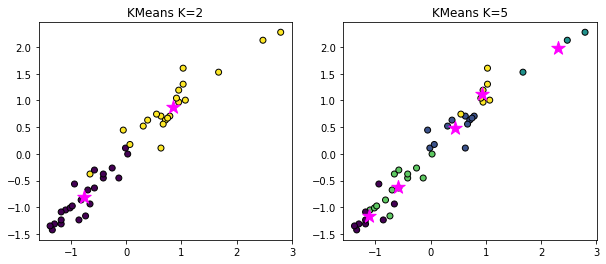

In [49]:
# Comparativa gráfica de modelos
# --------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Resultados para K = 2
# ==============================================================================
ax[0].scatter(
        x = salario_scaled[:, 0],
        y = salario_scaled[:, 1], 
        c = y_predict,
        marker    = 'o',
        edgecolor = 'black'
    )

ax[0].scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1], 
    c = 'magenta',
    s = 200,
    marker = '*',
    label  = 'centroides'
)

ax[0].set_title('KMeans K=2');

# Resultados para K = 5
# ---------------------------------------------------------------------
ax[1].scatter(
        x = salario_scaled[:, 0],
        y = salario_scaled[:, 1], 
        c = y_predict2,
        marker    = 'o',
        edgecolor = 'black'
    )
ax[1].scatter(
    x = modelo2_kmeans.cluster_centers_[:, 0],
    y = modelo2_kmeans.cluster_centers_[:, 1], 
    c = 'magenta',
    s = 200,
    marker = '*',
    label  = 'centroides'
)

ax[1].set_title('KMeans K=5');


Desde la revisión visual, se considera más adecuada la división de dos clusters, ya que existe mejor limitación de datos entre sí.

**Número de clusters: Comparativa**

Se revisará por dos técnicas distintas, cuál sería el número más adecuado para `k`.

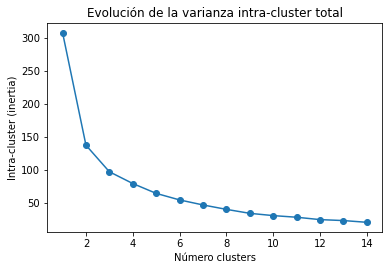

In [50]:
# Método elbow para identificar el número óptimo de clusters
# ---------------------------------------------------------------------
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo3_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 20, 
                        random_state = 123
                    )
    modelo3_kmeans.fit(salario_scaled)
    inertias.append(modelo3_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

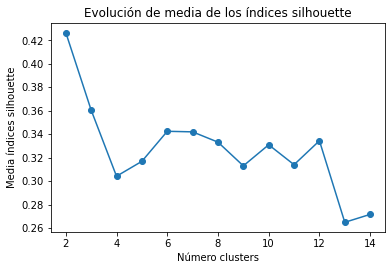

In [51]:
# Método silhouette para identificar el número óptimo de clusters
# ---------------------------------------------------------------------
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo5_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 20, 
                        random_state = 123
                    )
    cluster_labels = modelo5_kmeans.fit_predict(salario_scaled)
    silhouette_avg = silhouette_score(salario_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
    
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

De ambas técnicas se infiere, en general, que el número más adecuado de clústers en este caso, es `k = 2`.

### Dendrogramas

También se utilizará un clustering de los datos por técnica de agrupación jerárquica para revisar los resultados.

Se realizará una comparativa entre los `linkage` _"complete"_ , _"average"_ y _"average"_.

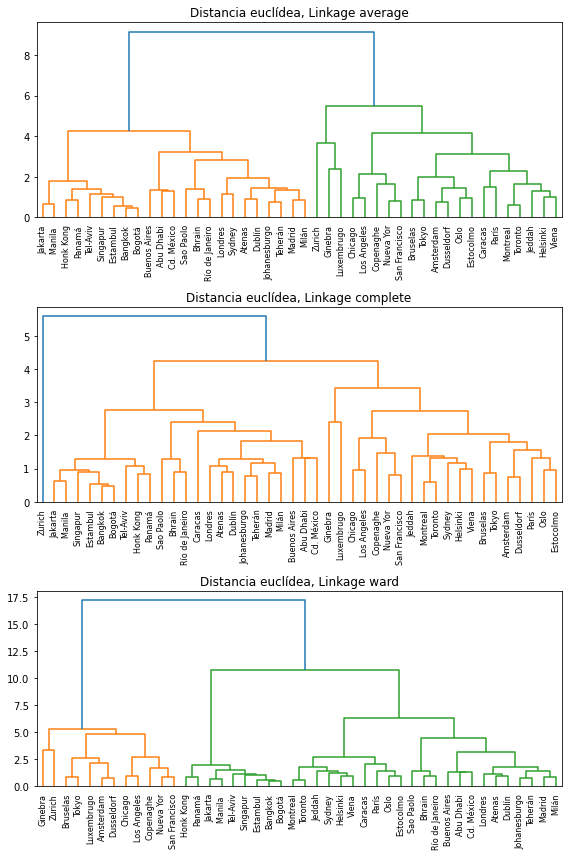

In [52]:
# Dendrogramas
# ---------------------------------------------------------------------
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

Z_complete = linkage(salario_scaled, 'complete')
dendrogram(Z_complete,
           color_threshold = 6,
           labels          = salario_s.index,
           ax              = axs[0]
               )
axs[1].set_title("Distancia euclídea, Linkage complete")

Z_average = linkage(salario_scaled, 'average')
dendrogram(Z_average, 
           color_threshold = 5,
           labels          = salario_s.index,
           ax              = axs[1]
               )
axs[0].set_title("Distancia euclídea, Linkage average")

Z_ward = linkage(salario_scaled, 'ward')
dendrogram(Z_ward,
           color_threshold = 12.5,
           labels          = salario_s.index,
           ax              = axs[2]
               )
axs[2].set_title("Distancia euclídea, Linkage ward")

plt.tight_layout();

Se observan en los 3 Dendrogramas que algunas similitudes, como la cercanía de las ciudades _Tel - Aviv, Jakarta y Manila_ , pero también se observa que dependiendo del `linkage` utilizado, _Zurich, Ginebra y Luxemburgo_ pueden quedar bajo el mismo cluster (de sueldos más altos), o bien separadas en dos sub grupos.

# Referencias

* PARDO, Mateo. Clustering. Nation Research Council (CNR) , Berlín Alemania, Disponible en: http://lectures.molgen.mpg.de/algsysbio10/clustering.pdf

* Spicy cluster docs https://docs.scipy.org/

* Vallat, R. (2018). Pingouin: statistics in Python. Journal of Open Source Software, 3(31), 1026, https://doi.org/10.21105/joss.01026